In [35]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [36]:
import numpy as np
import pandas as pd

In [37]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [39]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [41]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [45]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [46]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],['type]'])

id ['type]']
station ['type]']
date ['type]']
prcp ['type]']
tobs ['type]']


In [47]:
most_current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_current_date = str(most_current_date)[2:-3]
print(most_current_date)


last_date_measurement = engine.execute('SELECT max(date) FROM Measurement').fetchone()
print(last_date_measurement)

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

2017-08-23
('2017-08-23',)
('2017-08-23',)


In [48]:
date_12mnth = (dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()
print(date_12mnth)
twelve_mnth_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print( twelve_mnth_date)

2016-08-23
2016-08-23


In [50]:

prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= twelve_mnth_date ).\
order_by(Measurement.date).all()


prcp_df = pd.DataFrame(prcp)
prcp_index_df = prcp_df.set_index('date')
prcp_index_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


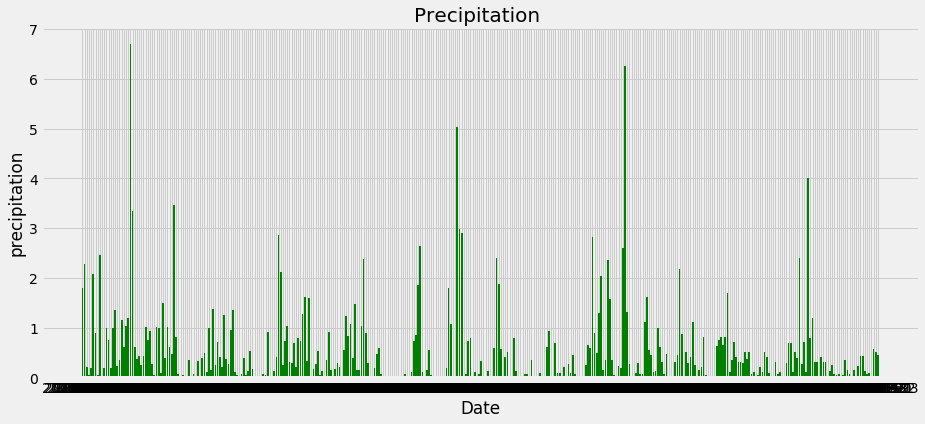

In [51]:

plt.figure(figsize=(14,6))
plt.bar(prcp_df['date'], prcp_df["prcp"], color='green', alpha=1.0, align="center")

plt.rc('axes', titlesize=20,)     
plt.rc('axes', labelsize= 20)    
plt.rc('figure', titlesize=10)
plt.title("Precipitation ")
plt.xlabel("Date")
plt.ylabel("precipitation")
plt.show()

![precipitation](Images/precipitation.png)

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_index_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [53]:
session.query(Measurement.station.distinct()).all()

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [54]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()
session.query(func.count(distinct(Measurement.station))).all()  


[(9)]

In [55]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [56]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],['type]'])

id ['type]']
station ['type]']
name ['type]']
latitude ['type]']
longitude ['type]']
elevation ['type]']


In [57]:
 session.query(Measurement.station, func.count(Measurement.prcp))\
             .group_by(Measurement.station).order_by(func.count(Measurement.prcp).desc()).all()



[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [58]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
\
             .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()


('USC00519281', 54.0, 85.0, 71.66378066378067)

In [108]:
session.query(Measurement.station,func.count(Measurement.tobs)).all()


[('USC00519397', 19550)]

<Figure size 432x288 with 0 Axes>

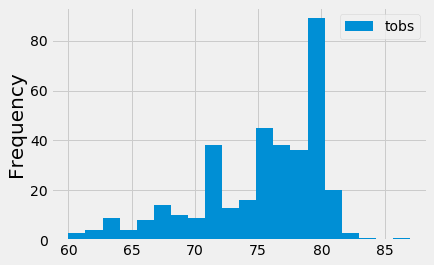

In [125]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station,func.max(Measurement.tobs)).all()
temp_station97 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter_by(station="USC00519397").filter(Measurement.date >= twelve_mnth_date ).all()
temp_station97_df = pd.DataFrame(temp_station97)
temp_station97_df.set_index("station").head()

plt.figure()
temp_station97_df.plot.hist(stacked=True, bins=20)

![precipitation](Images/station-histogram.png)

In [96]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [118]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.02777777777777, 78.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
